# Single Deal Image Variant Generation

This notebook allows you to:
1. Define a single deal ID and custom prompt
2. Generate a variant image using OpenAI
3. Store the image in S3
4. Display the result immediately

The prompt will automatically incorporate the deal's email subject and highlights while allowing customization.

## Setup and Configuration

In [1]:
import pandas as pd
import os
import psycopg2
from dotenv import load_dotenv
import boto3
import requests
import base64
from openai import OpenAI
from io import BytesIO
import tempfile
from IPython.display import Image, display
import json
from datetime import datetime

# Load environment variables
load_dotenv()
# Initialize OpenAI client
client = OpenAI(api_key=os.getenv('OPEN_AI_API_KEY'))
print(f"OpenAI client initialized with API key: {os.getenv('OPEN_AI_API_KEY')[:5]}...")

# Configure AWS credentials
s3_client = boto3.client(
    's3',
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY')
)

print("Setup complete!")

OpenAI client initialized with API key: sk-sv...
Setup complete!


## Configuration - Define Your Deal and Prompt

In [8]:
# ========== CONFIGURE THESE VALUES ==========

# Deal ID to process
DEAL_ID = 31341207  # Change this to your desired deal ID

# Custom prompt template - {email_subject} and {formatted_highlights} will be automatically replaced
CUSTOM_PROMPT = """Create ONE high-resolution, photo-realistic promotional image advertising {email_subject}.

Final image must contain zero spelling mistakes.

1. Service Representation
Visually communicate the core experience or service in an authentic and aspirational way.
Include people only if appropriate — expressions must look natural, relaxed, and genuinely engaged.
Avoid exaggerated or artificial staging.
Focus on one setting or moment that clearly represents the value of the experience.
If applicable, include accurate tools, furnishings, or attire that reflect the service.

2. Scene & Background
Place the experience in a realistic, appealing setting suited to the type of service.
Use natural lighting and soft depth of field to keep the service or activity as the clear focal point.
The background should feel aspirational but believable — it must not compete with or overshadow the subject.
Avoid busy or generic backdrops; choose settings that suggest quality, comfort, or excitement.

3. Infographic & Text Elements
Do not repeat the headline elsewhere in the image.
Overlay 2–4 short, benefit-led call-outs drawn from the highlights below, placed on the left side of the image.
{formatted_highlights}
Ensure all text and stickers avoid the bottom-right 20% of the image.
Choose clear, legible text with 4px padding around all elements.

4. Design Constraints
Keep the bottom-right corner completely clear of any graphics or text.
Do not include any pricing or logos unless specifically provided.
Ensure realism — no invented props, features, or environments.
Colour palettes, uniforms, and tools must accurately reflect the service being portrayed."""

print(f"Configuration set:")
print(f"Deal ID: {DEAL_ID}")
print(f"Custom prompt template ready (will be populated with deal data)")

Configuration set:
Deal ID: 31341207
Custom prompt template ready (will be populated with deal data)


## Database Functions

In [3]:
def get_deal_data_for_image(deal_id):
    """Get deal data needed for image generation"""
    # Establish connection to Redshift
    conn = psycopg2.connect(
        host=os.environ.get("REDSHIFT_HOST", "bi-redshift.intwowcher.co.uk"),
        port=os.environ.get("REDSHIFT_PORT", "5439"),
        dbname=os.environ.get("REDSHIFT_DBNAME", "wowdwhprod"),
        user=os.environ.get("REDSHIFT_USER", "jenkins"),
        password=os.environ.get("REDSHIFT_PASSWORD", "9SDy1ffdfTV7")
    )

    # Get email subject
    email_subject_query = """
    SELECT email_subject 
    FROM wowdwhprod.real.deal_voucher
    WHERE id = %s
    """
    with conn.cursor() as cur:
        cur.execute(email_subject_query, (deal_id,))
        email_subject_result = cur.fetchone()
        email_subject = email_subject_result[0] if email_subject_result else "Deal"

    # Get image URLs and extract extension information
    image_query = """
    SELECT 
        'https://static.wowcher.co.uk/images/deal/' || deal_voucher_id || '/' || id || '.' || extension AS image_url,
        extension,
        id as image_id
    FROM wowdwhprod.real.deal_voucher_image
    WHERE deal_voucher_id = %s
    ORDER BY position
    LIMIT 10
    """
    with conn.cursor() as cur:
        cur.execute(image_query, (deal_id,))
        image_results = cur.fetchall()
        image_urls = [row[0] for row in image_results]
        extensions = [row[1] for row in image_results]
        image_ids = [row[2] for row in image_results]
        original_extension = extensions[0] if extensions else "png"
        original_image_id = image_ids[0] if image_ids else None

    # Get highlights
    highlights_query = """
    SELECT
    SPLIT_PART(highlight, ':', 1) AS highlight
    FROM wowdwhprod.real.deal_voucher_highlight
    WHERE deal_voucher_id = %s
    LIMIT 3;
    """
    with conn.cursor() as cur:
        cur.execute(highlights_query, (deal_id,))
        highlights_results = cur.fetchall()
        highlights = [row[0] for row in highlights_results]

    conn.close()

    return {
        'email_subject': email_subject,
        'highlights': highlights,
        'image_urls': image_urls,
        'original_extension': original_extension,
        'original_image_id': original_image_id
    }

print("Database functions loaded")

Database functions loaded


## S3 Upload Function

In [4]:
def upload_to_s3(file_content, bucket_name, s3_key):
    """
    Upload a file to S3
    
    Parameters:
    - file_content: Binary content of the file
    - bucket_name: S3 bucket name
    - s3_key: Path in S3 where file will be stored
    
    Returns:
    - URL of the uploaded file
    """
    try:
        # Determine content type based on file extension
        extension = os.path.splitext(s3_key)[1].lower()
        content_type = 'image/jpeg' if extension in ['.jpg', '.jpeg'] else \
                      'image/png' if extension == '.png' else \
                      'image/webp' if extension == '.webp' else \
                      'application/octet-stream'
                      
        s3_client.put_object(
            Body=file_content,
            Bucket=bucket_name,
            Key=s3_key,
            ContentType=content_type
        )
        return f"https://static.wowcher.co.uk/{s3_key}"
    except Exception as e:
        print(f"Error uploading to S3: {str(e)}")
        return None

print("S3 upload function loaded")

S3 upload function loaded


## Image Generation Function

In [5]:
def download_image_to_file(url, filename):
    """Download an image from URL and save to file"""
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)
        return filename
    else:
        raise Exception(f"Failed to download image from {url}")

def generate_single_variant(deal_id, custom_prompt_template):
    """
    Generate a single image variant for the specified deal
    """
    print(f"Processing deal {deal_id}...")
    
    try:
        # Get deal data
        deal_data = get_deal_data_for_image(deal_id)
        
        email_subject = deal_data['email_subject']
        highlights = deal_data['highlights']
        image_urls = deal_data['image_urls']
        original_extension = deal_data['original_extension']
        original_image_id = deal_data['original_image_id']
        
        print(f"Deal: {email_subject}")
        print(f"Found {len(image_urls)} images")
        print(f"Highlights: {highlights}")
        
        if not image_urls:
            raise Exception("No images found for this deal")
        
        # Format highlights for prompt
        formatted_highlights = "\n".join([f"• {h}" for h in highlights]) if highlights else ""
        
        # Build the final prompt
        final_prompt = custom_prompt_template.format(
            email_subject=email_subject,
            formatted_highlights=formatted_highlights
        )
        
        print("\n=== FINAL PROMPT ===")
        print(final_prompt)
        print("==================\n")
        
        # Create temporary directory for processing
        with tempfile.TemporaryDirectory() as temp_dir:
            # Download images
            image_files = []
            temp_filenames = []
            
            print("Downloading source images...")
            for idx, url in enumerate(image_urls[:16]):
                temp_filename = os.path.join(temp_dir, f"temp_image_{deal_id}_{idx}.png")
                download_image_to_file(url, temp_filename)
                temp_filenames.append(temp_filename)
                image_files.append(open(temp_filename, "rb"))
            
            print(f"Downloaded {len(image_files)} images")
            print("Generating variant with OpenAI...")
            
            # Call OpenAI API
            result = client.images.edit(
                model="gpt-image-1",
                image=image_files,
                prompt=final_prompt,
                size="1536x1024",
                quality="high",
                background="auto",
                n=1
            )
            
            # Process the response
            image_base64 = result.data[0].b64_json
            image_bytes = base64.b64decode(image_base64)
            
            # Close file handles
            for f in image_files:
                f.close()
            
            # Upload to S3
            print("Uploading to S3...")
            s3_key = f"images/deal/{deal_id}/{original_image_id}_variant_{datetime.now().strftime('%Y%m%d_%H%M%S')}.{original_extension}"
            s3_url = upload_to_s3(image_bytes, 'static.wowcher.co.uk', s3_key)
            
            # Process token usage
            token_info = {}
            if hasattr(result, 'usage'):
                total_tokens = result.usage.total_tokens
                input_tokens = result.usage.input_tokens
                output_tokens = result.usage.output_tokens
                input_text_tokens = result.usage.input_tokens_details.text_tokens
                input_image_tokens = result.usage.input_tokens_details.image_tokens
                
                # Calculate cost
                cost = (input_text_tokens * 5 + input_image_tokens * 10 + output_tokens * 40) / 1000000
                
                token_info = {
                    "total_tokens": total_tokens,
                    "input_tokens": input_tokens,
                    "output_tokens": output_tokens,
                    "input_text_tokens": input_text_tokens,
                    "input_image_tokens": input_image_tokens,
                    "cost": cost
                }
                
                print(f"\nGeneration cost: ${cost:.6f}")
            
            return {
                'success': True,
                'deal_id': deal_id,
                'email_subject': email_subject,
                'highlights': highlights,
                's3_url': s3_url,
                's3_key': s3_key,
                'image_bytes': image_bytes,
                'token_info': token_info,
                'original_image_id': original_image_id,
                'original_extension': original_extension,
                'prompt_used': final_prompt,
                'timestamp': datetime.now().isoformat()
            }
            
    except Exception as e:
        print(f"Error generating variant: {str(e)}")
        return {
            'success': False,
            'deal_id': deal_id,
            'error': str(e),
            'timestamp': datetime.now().isoformat()
        }

print("Image generation function loaded")

Image generation function loaded


## Generate and Display Variant

This cell will generate the variant based on your configuration above and display the results.

Processing deal 31341207...
Deal: BYOB Pottery Painting Experience
Found 10 images
Highlights: ['<b>BYOB', '<b>Location', '<b>Paint']

=== FINAL PROMPT ===
Create ONE high-resolution, photo-realistic promotional image advertising BYOB Pottery Painting Experience.

Final image must contain zero spelling mistakes.

1. Service Representation
Visually communicate the core experience or service in an authentic and aspirational way.
Include people only if appropriate — expressions must look natural, relaxed, and genuinely engaged.
Avoid exaggerated or artificial staging.
Focus on one setting or moment that clearly represents the value of the experience.
If applicable, include accurate tools, furnishings, or attire that reflect the service.

2. Scene & Background
Place the experience in a realistic, appealing setting suited to the type of service.
Use natural lighting and soft depth of field to keep the service or activity as the clear focal point.
The background should feel aspirational but 

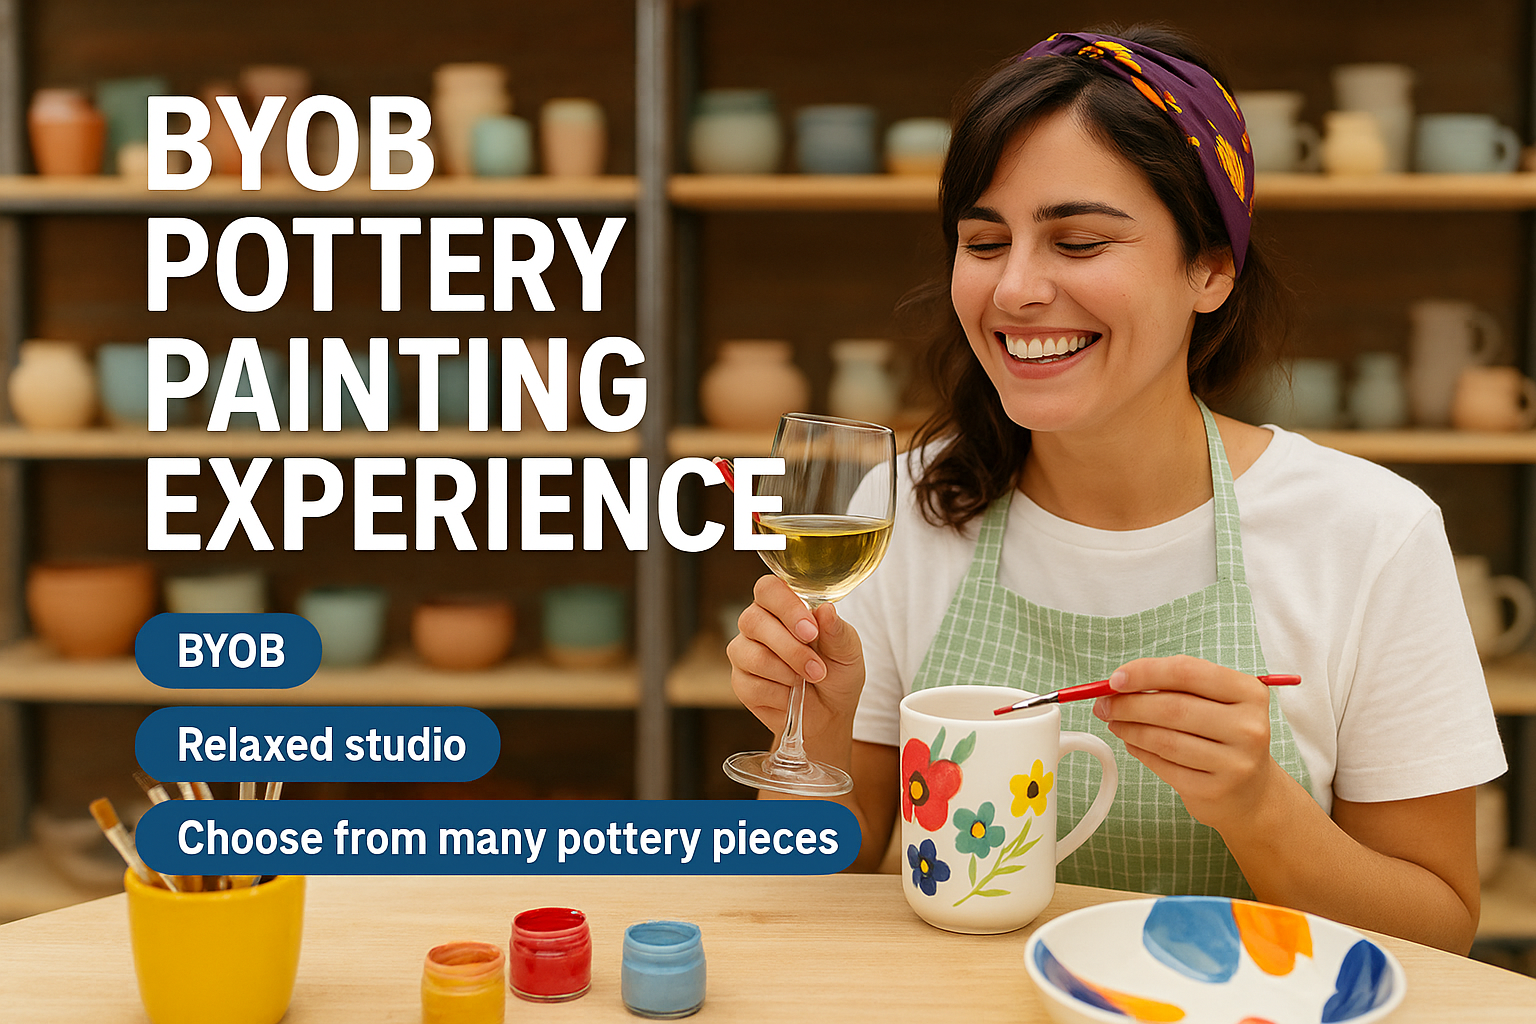


📁 Result saved to: variant_result_31341207_20250611_093712.json


In [9]:
# Generate the variant
result = generate_single_variant(DEAL_ID, CUSTOM_PROMPT)

# Display results
if result['success']:
    print("\n🎉 SUCCESS! Variant generated successfully")
    print(f"\nDeal ID: {result['deal_id']}")
    print(f"Email Subject: {result['email_subject']}")
    print(f"S3 URL: {result['s3_url']}")
    
    if 'token_info' in result:
        token_info = result['token_info']
        print(f"\n💰 Cost Information:")
        print(f"Total tokens: {token_info['total_tokens']:,}")
        print(f"Cost: ${token_info['cost']:.6f}")
    
    # Display the generated image
    print("\n🖼️ Generated Image:")
    display(Image(data=result['image_bytes']))
    
    # Save result to JSON for reference
    result_copy = result.copy()
    # Remove binary data for JSON serialization
    if 'image_bytes' in result_copy:
        del result_copy['image_bytes']
    
    filename = f"variant_result_{DEAL_ID}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    with open(filename, 'w') as f:
        json.dump(result_copy, f, indent=2)
    print(f"\n📁 Result saved to: {filename}")
    
else:
    print("\n❌ FAILED to generate variant")
    print(f"Error: {result['error']}")
    print(f"Deal ID: {result['deal_id']}")

## Quick Reference

To generate another variant:
1. Go back to the "Configuration" cell
2. Change the `DEAL_ID` and/or modify the `CUSTOM_PROMPT` 
3. Run the "Configuration" cell again
4. Run the "Generate and Display Variant" cell

The prompt template supports these placeholders:
- `{email_subject}` - Will be replaced with the deal's email subject
- `{formatted_highlights}` - Will be replaced with the deal's highlights formatted as bullet points

## View Original Images (Optional)

Run this cell to see the original images for the current deal ID

Original images for Deal 31341207: BYOB Pottery Painting Experience
Highlights: ['<b>BYOB', '<b>Location', '<b>Paint']

Original Images:

Image 1: https://static.wowcher.co.uk/images/deal/31341207/1540697.jpg


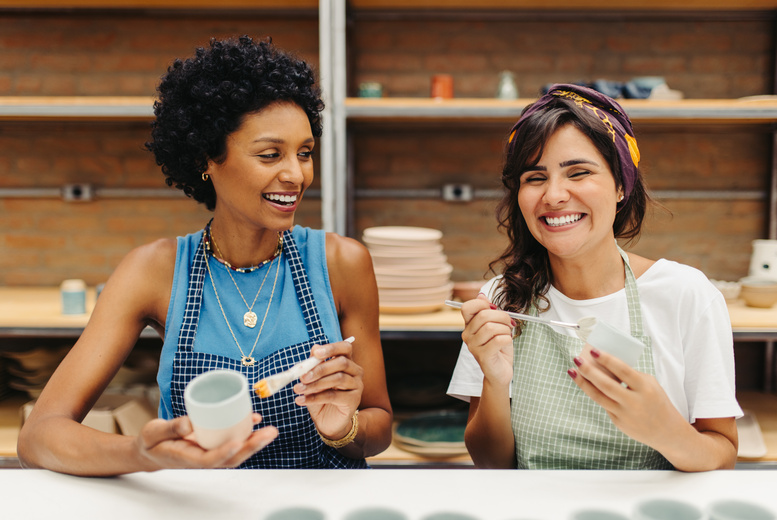


Image 2: https://static.wowcher.co.uk/images/deal/31341207/1554364.jpg


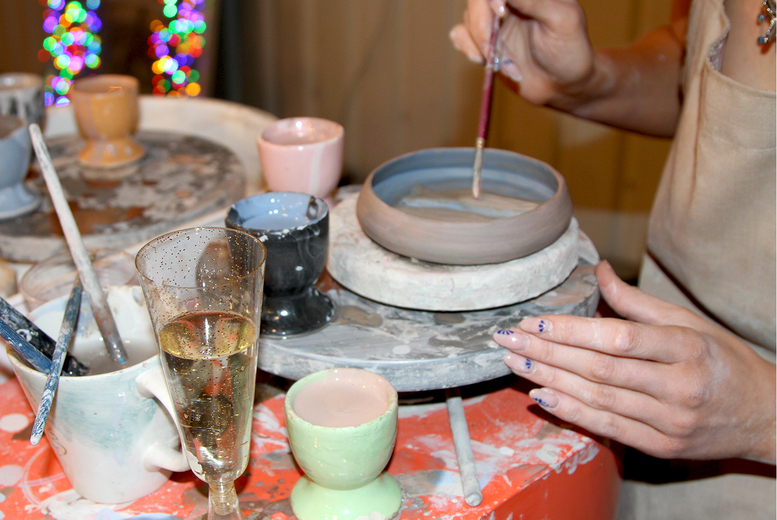


Image 3: https://static.wowcher.co.uk/images/deal/31341207/1554365.jpg


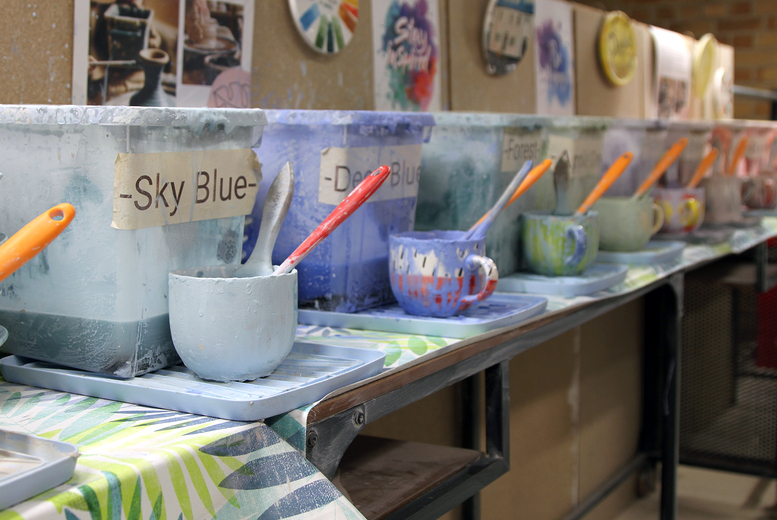

In [10]:
# Get deal data to show original images
deal_data = get_deal_data_for_image(DEAL_ID)

print(f"Original images for Deal {DEAL_ID}: {deal_data['email_subject']}")
print(f"Highlights: {deal_data['highlights']}")
print("\nOriginal Images:")

for i, url in enumerate(deal_data['image_urls'][:3]):  # Show first 3 images
    print(f"\nImage {i+1}: {url}")
    try:
        response = requests.get(url)
        if response.status_code == 200:
            display(Image(data=response.content, width=300))
    except Exception as e:
        print(f"Could not display image: {e}")